<a href="https://colab.research.google.com/github/oykudemirel/DSA-210-PROJECT/blob/main/dsa210project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Get the tmdb list which has all the movies

import requests
import time
import pandas as pd

API_KEY = '823fecbf63a8e7692fe9329ead448aac'
base_url = "https://api.themoviedb.org/3/discover/movie"

all_movies = []

for year in range(2016, 2021):
    print(f"Processing year: {year}")
    page = 1

    while True:
        params = {
    "api_key": API_KEY,
    "primary_release_year": year,
    "sort_by": "popularity.desc",  # Sort results so we get the most relevant
    "vote_count.gte": 10,          # Only include movies with at least 10 votes
    "page": page
}


        response = requests.get(base_url, params=params)
        data = response.json()

        if 'results' not in data or len(data['results']) == 0:
            print("No results, stopping...")
            break

        for movie in data['results']:
            title = movie.get('title', '')
            release_date = movie.get('release_date', '')

            if release_date:
                year_part = int(release_date.split('-')[0])
                month_part = int(release_date.split('-')[1])
            else:
                year_part = year
                month_part = None

            all_movies.append({
                "Title": title,
                "Release Year": year_part,
                "Release Month": month_part,
                "Release Date": release_date
            })

        if page >= data.get('total_pages', 1):
            break
        page += 1
        time.sleep(0.3)


df = pd.DataFrame(all_movies)
df.to_csv("tmdb_movies_2016_2020.csv", index=False)
print(df.head())



Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
                                Title  Release Year  Release Month  \
0  Batman v Superman: Dawn of Justice          2016              3   
1               The Girl on the Train          2016             10   
2                      The Accountant          2016             10   
3              Underworld: Blood Wars          2016             11   
4                           Moonlight          2016             10   

  Release Date  
0   2016-03-23  
1   2016-10-05  
2   2016-10-13  
3   2016-11-24  
4   2016-10-21  


In [ ]:
# Categorize the seasons
def categorize_season(month):
    if month in [11, 12]:
        return 'Holiday Season'
    elif month in [1, 2, 9, 10]:
        return 'Awards Season'
    elif month in [6, 7, 8]:
        return 'Summer Blockbuster'
    elif month in [3, 4, 5]:
        return 'Spring'
    else:
        return 'Other'  # For missing or weird months

df['Release Season'] = df['Release Month'].apply(categorize_season)


print(df[['Title', 'Release Year', 'Release Month', 'Release Season']].head())


                                Title  Release Year  Release Month  \
0  Batman v Superman: Dawn of Justice          2016              3   
1               The Girl on the Train          2016             10   
2                      The Accountant          2016             10   
3              Underworld: Blood Wars          2016             11   
4                           Moonlight          2016             10   

   Release Season  
0          Spring  
1   Awards Season  
2   Awards Season  
3  Holiday Season  
4   Awards Season  


Release Season
Awards Season         6060
Spring                3653
Summer Blockbuster    3427
Holiday Season        2856
Name: count, dtype: int64


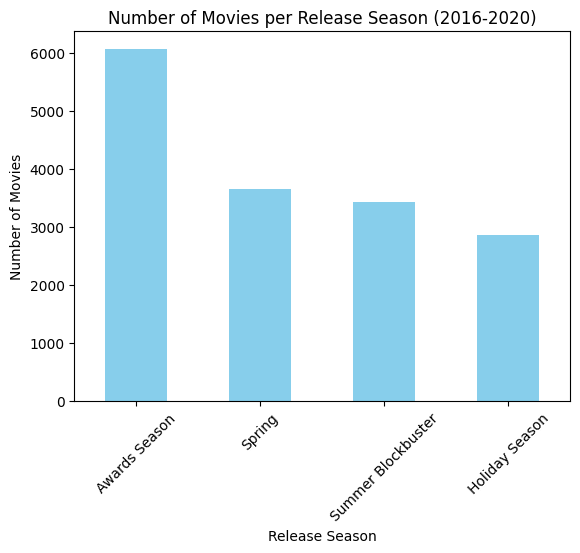

In [ ]:
# Movies per Release Season
season_counts = df['Release Season'].value_counts()
print(season_counts)


import matplotlib.pyplot as plt

season_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies per Release Season (2016-2020)')
plt.ylabel('Number of Movies')
plt.xlabel('Release Season')
plt.xticks(rotation=45)
plt.show()


In [ ]:
#Web scraped the website Box Office Mojo to get the box office numbers
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

pd.set_option('display.float_format', '{:.0f}'.format)

years = list(range(2016, 2021))

base_url = "https://www.boxofficemojo.com/year/world/{year}/"


all_data = []

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

for year in years:
    print(f"Processing year: {year}")
    url = base_url.format(year=year)
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Failed to retrieve data for {year}: {e}")
        continue

    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table containing the box office data
    table = soup.find('table')
    if not table:
        print(f"No table found for {year}")
        continue

    # Extract table rows, skip header row,
    rows = table.find_all('tr')[1:]

    for row in rows:
        cols = row.find_all('td')
        if len(cols) < 3:
            continue  # Skip rows that don't have enough columns
        release_group = cols[1].get_text(strip=True)
        worldwide_gross = cols[2].get_text(strip=True)
        all_data.append({
            'Year': year,
            'Release Group': release_group,
            'Worldwide Gross': worldwide_gross
        })


    time.sleep(1)


df_box_office = pd.DataFrame(all_data)



# Remove dollar signs and commas and convert to numeric
df_box_office['Worldwide Gross'] = df_box_office['Worldwide Gross'].replace('[\$,]', '', regex=True).astype(float)


print(df_box_office.head())


Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
   Year                 Release Group  Worldwide Gross
0  2016    Captain America: Civil War       1153296293
1  2016  Rogue One: A Star Wars Story       1056057273
2  2016                  Finding Dory       1028570889
3  2016                      Zootopia       1023784195
4  2016               The Jungle Book        966550600


In [ ]:
#Normalize titles
def normalize_title(title):
    if pd.isnull(title):
        return ""
    return title.lower().strip()


df['normalized_title'] = df['Title'].apply(normalize_title)
df_box_office['normalized_title'] = df_box_office['Release Group'].apply(normalize_title)

#Merge on normalized titles and year
merged_df = pd.merge(
    df,
    df_box_office,
    left_on=['normalized_title', 'Release Year'],
    right_on=['normalized_title', 'Year'],
    how='left'
)

#Fix the _x and _y
def clean_merge_columns(df, prefer='_x'):

    for col in df.columns:
        if col.endswith(prefer):
            base = col[:-2]  # remove _x or _y
            other = base + ('_y' if prefer == '_x' else '_x')
            if other in df.columns:
                df = df.drop(columns=[other])
            df = df.rename(columns={col: base})
    return df

merged_df = clean_merge_columns(merged_df)

merged_df.drop(columns=['normalized_title', 'Year'], errors='ignore', inplace=True)

print(merged_df[['Title', 'Release Year', 'Release Month', 'Release Season', 'Worldwide Gross']].head())


                                Title  Release Year  Release Month  \
0  Batman v Superman: Dawn of Justice          2016              3   
1               The Girl on the Train          2016             10   
2                      The Accountant          2016             10   
3              Underworld: Blood Wars          2016             11   
4                           Moonlight          2016             10   

   Release Season  Worldwide Gross  
0          Spring        874360194  
1   Awards Season        173185859  
2   Awards Season        155560045  
3  Holiday Season         81093313  
4   Awards Season         65172611  


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oykudemirell","key":"b41ccc22de14a9a86f326e961286b890"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d unanimad/bafta-awards

!unzip -o bafta-awards.zip
!ls

Dataset URL: https://www.kaggle.com/datasets/unanimad/bafta-awards
License(s): CC0-1.0
Archive:  bafta-awards.zip
  inflating: bafta_films.csv         
bafta-awards.zip  kaggle.json  tmdb_movies_2016_2020.csv
bafta_films.csv   sample_data


In [ ]:
#BAFTA Awards
import pandas as pd

df_b = pd.read_csv('bafta_films.csv')


df_b['year'] = pd.to_numeric(df_b['year'], errors='coerce')

df_b = df_b[(df_b['year'] >= 2016) & (df_b['year'] <= 2020)]

#Drop unnecessary columns
df_b = df_b.drop(columns=['category', 'workers'])

df_b.head()


,year,nominee,winner
3575,2016,The Big Short,True
3576,2016,Brooklyn,False
3577,2016,Carol,False
3578,2016,Room,False
3579,2016,Steve Jobs,False


In [ ]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"oykudemirell","key":"ebf90736d0540d12a0d387475a61f434"}'}

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp "kaggle (1).json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d unanimad/golden-globe-awards
!unzip -o golden-globe-awards.zip
!ls


Dataset URL: https://www.kaggle.com/datasets/unanimad/golden-globe-awards
License(s): CC0-1.0
Archive:  golden-globe-awards.zip
  inflating: golden_globe_awards.csv  
 bafta-awards.zip	   golden-globe-awards.zip   sample_data
 bafta_films.csv	  'kaggle (1).json'	     tmdb_movies_2016_2020.csv
 golden_globe_awards.csv   kaggle.json


In [ ]:
#Golden Globe Awards
import pandas as pd


df_gg = pd.read_csv('golden_globe_awards.csv')

# Filter by year and drop unnecessary columns
df_gg['year_film'] = pd.to_numeric(df_gg['year_film'], errors='coerce')
df_gg = df_gg[(df_gg['year_film'] >= 2016) & (df_gg['year_film'] <= 2020)]

df_gg = df_gg.dropna(subset=['film'])

df_gg = df_gg.drop(columns=['year_award', 'ceremony', 'category', 'nominee'])


df_gg.head()


,year_film,film,win
7494,2016,Elle,True
7495,2016,Arrival,False
7496,2016,Miss Sloane,False
7497,2016,Loving,False
7498,2016,Jackie,False


In [ ]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"oykudemirell","key":"24fc20083ed3bb7604f8159dd18baa8c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp "kaggle (2).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle


In [ ]:
!kaggle datasets download -d unanimad/the-oscar-award
!unzip -o the-oscar-award.zip
!ls


Dataset URL: https://www.kaggle.com/datasets/unanimad/the-oscar-award
License(s): CC0-1.0
Archive:  the-oscar-award.zip
  inflating: full_data.csv           
  inflating: the_oscar_award.csv     
 bafta-awards.zip	   golden-globe-awards.zip   sample_data
 bafta_films.csv	  'kaggle (1).json'	     the_oscar_award.csv
 full_data.csv		  'kaggle (2).json'	     the-oscar-award.zip
 golden_globe_awards.csv   kaggle.json		     tmdb_movies_2016_2020.csv


In [ ]:
#Oscar Awards
import pandas as pd

df_oscar = pd.read_csv('the_oscar_award.csv')

df_oscar = df_oscar.drop(columns=['year_ceremony', 'ceremony', 'category', 'canon_category', 'name'], errors='ignore')


df_oscar = df_oscar[(df_oscar['year_film'] >= 2016) & (df_oscar['year_film'] <= 2020)]

df_oscar.head()


,year_film,film,winner
9984,2016,Manchester by the Sea,True
9985,2016,Hacksaw Ridge,False
9986,2016,La La Land,False
9987,2016,Captain Fantastic,False
9988,2016,Fences,False


In [ ]:
print(df_oscar.columns)
print(df_gg.columns)
print(df_b.columns)


Index(['year_film', 'film', 'winner'], dtype='object')
Index(['year_film', 'film', 'win'], dtype='object')
Index(['year', 'nominee', 'winner'], dtype='object')


In [ ]:
# Standardize columns

# Oscars
df_oscar = df_oscar.rename(columns={
    'film': 'Title',
    'year_film': 'Release Year'
})

# Golden Globes
df_gg = df_gg.rename(columns={
    'film': 'Title',
    'year_film': 'Release Year'
})

# BAFTA
df_b = df_b.rename(columns={
    'nominee': 'Title',
    'year': 'Release Year'
})



In [ ]:
print(df_oscar.columns)
print(df_gg.columns)
print(df_b.columns)


Index(['Release Year', 'Title', 'winner'], dtype='object')
Index(['Release Year', 'Title', 'win'], dtype='object')
Index(['Release Year', 'Title', 'winner'], dtype='object')


In [ ]:

def normalize_title(title):
    if pd.isna(title):
        return ''
    return title.lower().strip()

df_oscar['normalized_title'] = df_oscar['Title'].apply(normalize_title)
df_gg['normalized_title'] = df_gg['Title'].apply(normalize_title)
df_b['normalized_title'] = df_b['Title'].apply(normalize_title)

#Count how many wins each movie had per award show
df_oscar_counts = df_oscar.groupby('normalized_title').size().reset_index(name='Oscar_Win')
df_gg_counts = df_gg.groupby('normalized_title').size().reset_index(name='GG_Win')
df_b_counts = df_b.groupby('normalized_title').size().reset_index(name='BAFTA_Win')

#Merge
merged_df2 = df_oscar_counts.merge(df_gg_counts, on='normalized_title', how='outer')
merged_df2 = merged_df2.merge(df_b_counts, on='normalized_title', how='outer')

#Fill missing values with 0
merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']] = merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']].fillna(0).astype(int)

#Calculate the total number of awards won
merged_df2['Total_Awards_Won'] = merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']].sum(axis=1)


merged_df2 = merged_df2.merge(df_oscar[['normalized_title', 'Title', 'Release Year']], on='normalized_title', how='left')


merged_df2 = merged_df2.dropna(subset=['Title']).reset_index(drop=True)

print(merged_df2[['Title', 'Release Year', 'Oscar_Win', 'GG_Win', 'BAFTA_Win', 'Total_Awards_Won']].head())


                                       Title  Release Year  Oscar_Win  GG_Win  \
0  13 Hours: The Secret Soldiers of Benghazi          2016          1       0   
1                                       13th          2016          1       0   
2                                       1917          2019          1       1   
3                         20th Century Women          2016          1       1   
4                                  4.1 Miles          2016          1       0   

   BAFTA_Win  Total_Awards_Won  
0          0                 1  
1          1                 2  
2          1                 3  
3          0                 2  
4          0                 1  


<ipython-input-24-4deb32b13d51>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oscar['normalized_title'] = df_oscar['Title'].apply(normalize_title)


In [ ]:
print(merged_df2.columns)


Index(['normalized_title', 'Oscar_Win', 'GG_Win', 'BAFTA_Win',
       'Total_Awards_Won', 'Title', 'Release Year'],
      dtype='object')


In [ ]:
print(merged_df.columns)


Index(['Title', 'Release Year', 'Release Month', 'Release Date',
       'Release Season', 'Release Group', 'Worldwide Gross'],
      dtype='object')


In [ ]:
# Merge the clean movies/box office data (merged_df) with awards data (merged_df2)
final_df = pd.merge(
    merged_df,
    merged_df2[['Title', 'Release Year', 'Oscar_Win', 'GG_Win', 'BAFTA_Win', 'Total_Awards_Won']],
    on=['Title', 'Release Year'],
    how='left'
)

print(final_df.head())


                                Title  Release Year  Release Month  \
0  Batman v Superman: Dawn of Justice          2016              3   
1               The Girl on the Train          2016             10   
2                      The Accountant          2016             10   
3              Underworld: Blood Wars          2016             11   
4                           Moonlight          2016             10   

  Release Date  Release Season                       Release Group  \
0   2016-03-23          Spring  Batman v Superman: Dawn of Justice   
1   2016-10-05   Awards Season               The Girl on the Train   
2   2016-10-13   Awards Season                      The Accountant   
3   2016-11-24  Holiday Season              Underworld: Blood Wars   
4   2016-10-21   Awards Season                           Moonlight   

   Worldwide Gross  Oscar_Win  GG_Win  BAFTA_Win  Total_Awards_Won  
0        874360194        NaN     NaN        NaN               NaN  
1        173185859  

In [ ]:
# Fill NaN award counts with 0
award_cols = ['Oscar_Win', 'GG_Win', 'BAFTA_Win', 'Total_Awards_Won']
final_df[award_cols] = final_df[award_cols].fillna(0).astype(int)


final_df = final_df.drop(columns=['Release Group'])

print(final_df.head())



                                Title  Release Year  Release Month  \
0  Batman v Superman: Dawn of Justice          2016              3   
1               The Girl on the Train          2016             10   
2                      The Accountant          2016             10   
3              Underworld: Blood Wars          2016             11   
4                           Moonlight          2016             10   

  Release Date  Release Season  Worldwide Gross  Oscar_Win  GG_Win  BAFTA_Win  \
0   2016-03-23          Spring        874360194          0       0          0   
1   2016-10-05   Awards Season        173185859          0       0          0   
2   2016-10-13   Awards Season        155560045          0       0          0   
3   2016-11-24  Holiday Season         81093313          0       0          0   
4   2016-10-21   Awards Season         65172611          1       1          1   

   Total_Awards_Won  
0                 0  
1                 0  
2                 0  
3   

In [ ]:
final_df.to_csv('final_dataset.csv', index=False)


In [ ]:
from google.colab import files
files.download('final_dataset.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(final_df.columns)



Index(['Title', 'Release Year', 'Release Month', 'Release Date',
       'Release Season', 'Worldwide Gross', 'Oscar_Win', 'GG_Win', 'BAFTA_Win',
       'Total_Awards_Won'],
      dtype='object')


<ipython-input-41-3cbfaef5cc92>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=final_df, x='Release Month', y='Total_Awards_Won', estimator=np.mean, ci=None, palette="viridis")
<ipython-input-41-3cbfaef5cc92>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_df, x='Release Month', y='Total_Awards_Won', estimator=np.mean, ci=None, palette="viridis")


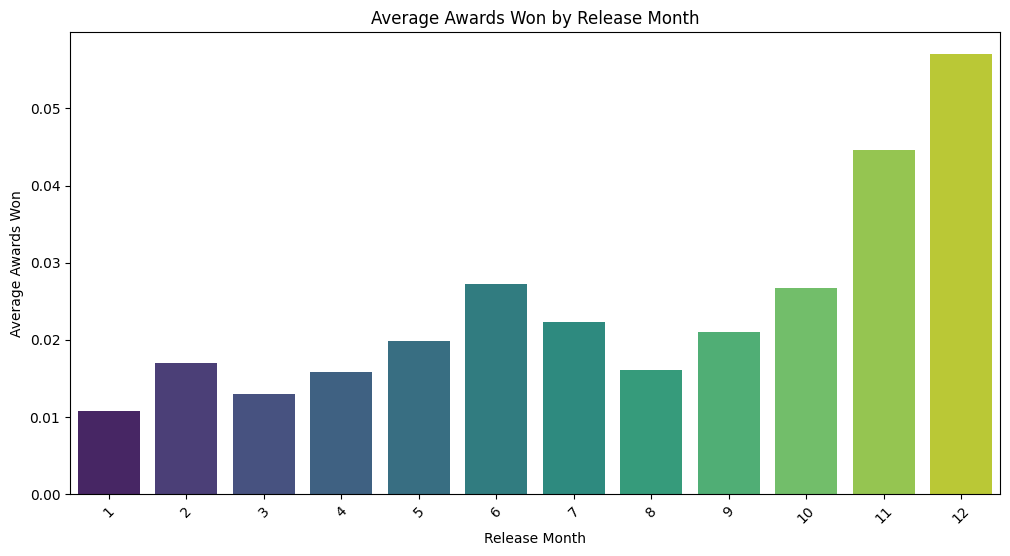

In [41]:
import numpy as np

plt.figure(figsize=(12,6))
sns.barplot(data=final_df, x='Release Month', y='Total_Awards_Won', estimator=np.mean, ci=None, palette="viridis")
plt.title('Average Awards Won by Release Month')
plt.ylabel('Average Awards Won')
plt.xlabel('Release Month')
plt.xticks(rotation=45)
plt.show()


The bar plot shows that movies released later in the year (November and December) tend to win more awards on average than movies released earlier. December releases have the highest average awards won, suggesting an advantage. In contrast, movies released between January and August tend to win fewer awards on average, indicating that early-year releases are less likely to become award-season favorites.

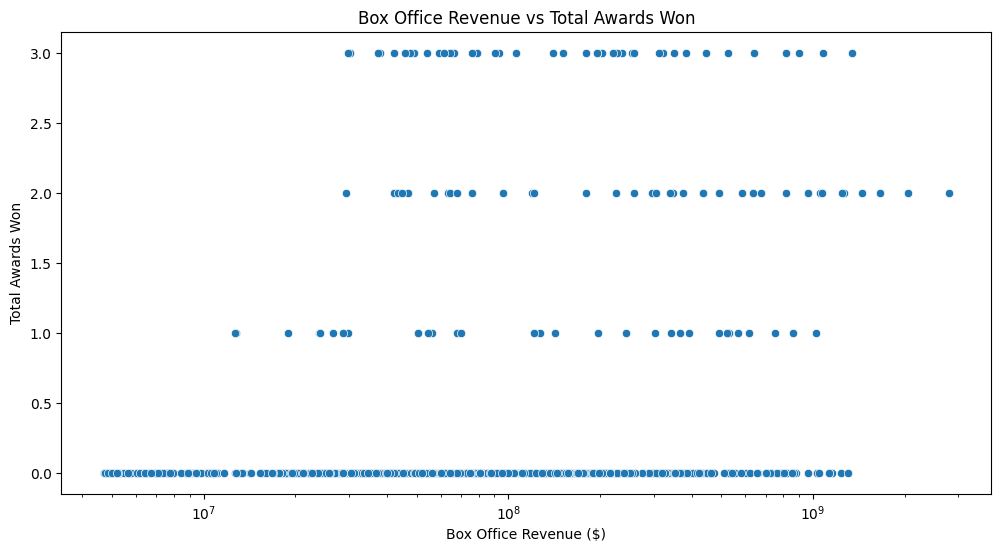

In [43]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=final_df, x='Worldwide Gross', y='Total_Awards_Won')
plt.title('Box Office Revenue vs Total Awards Won')
plt.xlabel('Box Office Revenue ($)')
plt.ylabel('Total Awards Won')
plt.xscale('log')  # because box office values vary a lot
plt.show()


There isn’t a strong relationship between box office revenue and total awards won. Many movies, even with very high revenue (over $1B), still won 0 or 1 award.

In [45]:
# Drop rows with NaNs
clean_df = final_df[['Worldwide Gross', 'Total_Awards_Won']].dropna()


pearson_corr, pearson_p = pearsonr(clean_df['Worldwide Gross'], clean_df['Total_Awards_Won'])
spearman_corr, spearman_p = spearmanr(clean_df['Worldwide Gross'], clean_df['Total_Awards_Won'])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")


Pearson correlation: 0.278 (p-value: 0.000)
Spearman correlation: 0.261 (p-value: 0.000)


While movies with higher box office revenues tend to win slightly more awards, box office success does not strongly predict award wins. Many blockbuster movies still win few or no awards, and some lower-revenue films can win big.

In [50]:
import pandas as pd
from scipy.stats import chi2_contingency

# 1. Create a binary column for “won any award”
final_df['Won_Award'] = final_df['Total_Awards_Won'] > 0

season_award_crosstab = pd.crosstab(
    final_df['Release Season'],
    final_df['Won_Award']
)
print(season_award_crosstab)


Won_Award           False  True 
Release Season                  
Awards Season        5981     79
Holiday Season       2783     73
Spring               3614     39
Summer Blockbuster   3378     49


In [52]:
# Chi-square test
chi2, p, dof, expected = chi2_contingency(season_award_crosstab)

print(f"Chi-Square statistic: {chi2:.3f}")
print(f"p-value: {p:.3f}")



Chi-Square statistic: 27.868
p-value: 0.000


Out of 6 k movies released in Awards Season, only 79 won at least one major award (%1.3). Holiday Season movies had a slightly higher success rate.

p < 0.05, so we reject H₀: there is a significant association between release season and winning awards.
The chance of winning at least one award does depend on when a movie is released.






In [63]:
from scipy.stats import ttest_ind


winners = final_df[ final_df['Won_Award'] ]['Worldwide Gross']
losers  = final_df[~final_df['Won_Award'] ]['Worldwide Gross']

# T-test
t_stat, p_val = ttest_ind(winners, losers, equal_var=False)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.3f}")


t-statistic: nan
p-value: nan


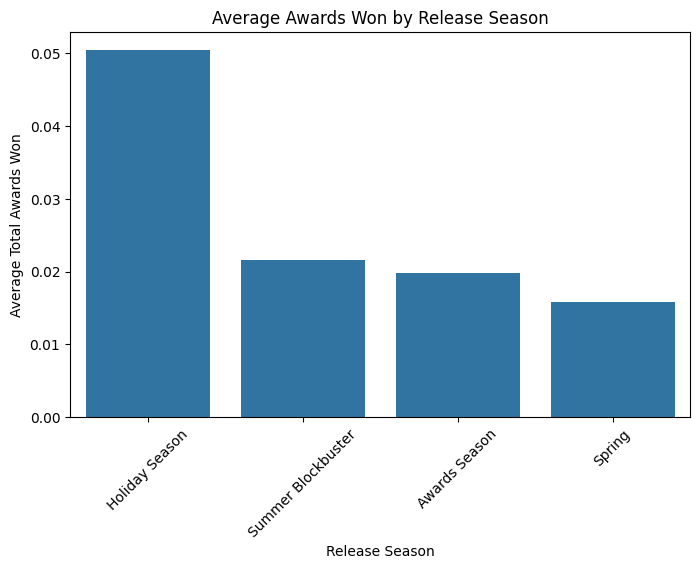

In [54]:
#Average Awards Won by Release Season
season_awards = final_df.groupby('Release Season')['Total_Awards_Won'].mean().sort_values(ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x=season_awards.index, y=season_awards.values)
plt.title('Average Awards Won by Release Season')
plt.xlabel('Release Season')
plt.ylabel('Average Total Awards Won')
plt.xticks(rotation=45)
plt.show()


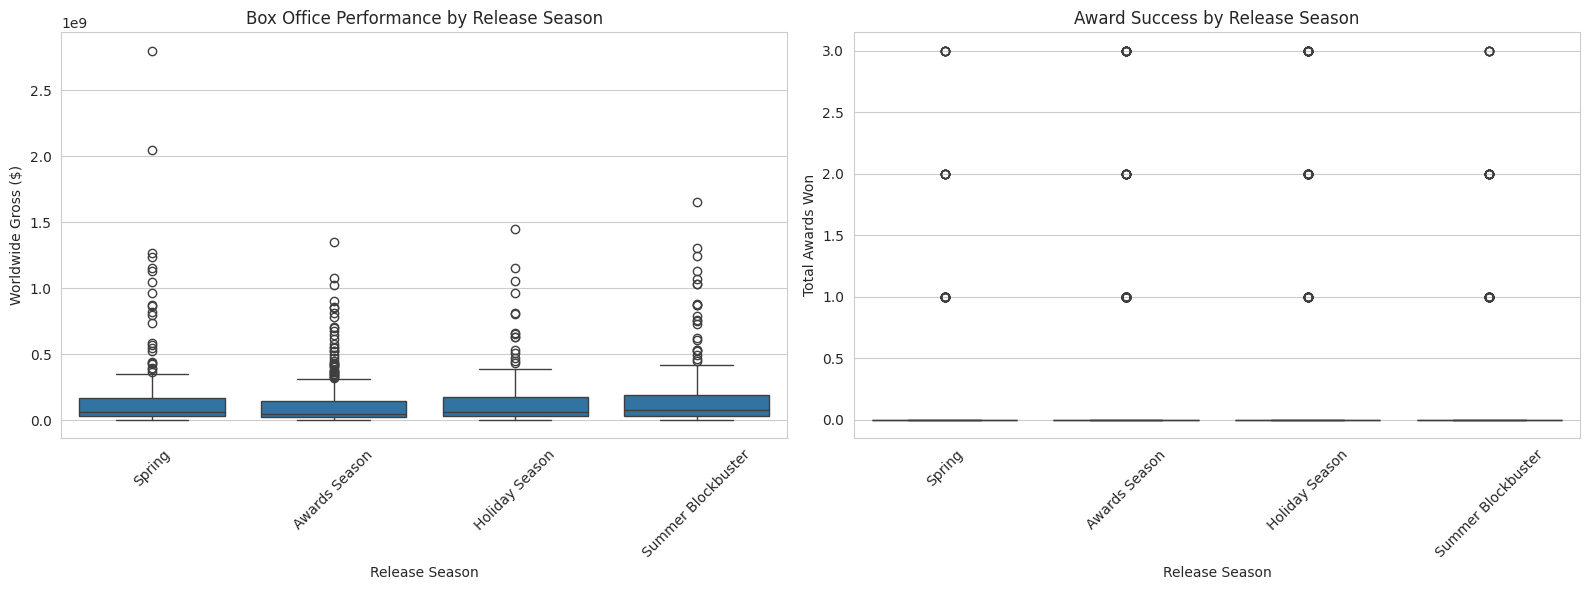

In [55]:

sns.set_style('whitegrid')


fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Plot 1: Box Office performance by Release Season
sns.boxplot(x='Release Season', y='Worldwide Gross', data=final_df, ax=axes[0])
axes[0].set_title('Box Office Performance by Release Season')
axes[0].set_ylabel('Worldwide Gross ($)')
axes[0].set_xlabel('Release Season')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Award success by Release Season
sns.boxplot(x='Release Season', y='Total_Awards_Won', data=final_df, ax=axes[1])
axes[1].set_title('Award Success by Release Season')
axes[1].set_ylabel('Total Awards Won')
axes[1].set_xlabel('Release Season')
axes[1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()


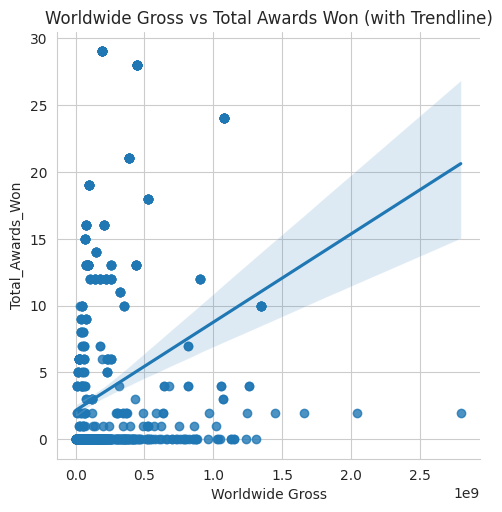

In [ ]:
sns.lmplot(x='Worldwide Gross', y='Total_Awards_Won', data=final_df)
plt.title('Worldwide Gross vs Total Awards Won (with Trendline)')
plt.show()


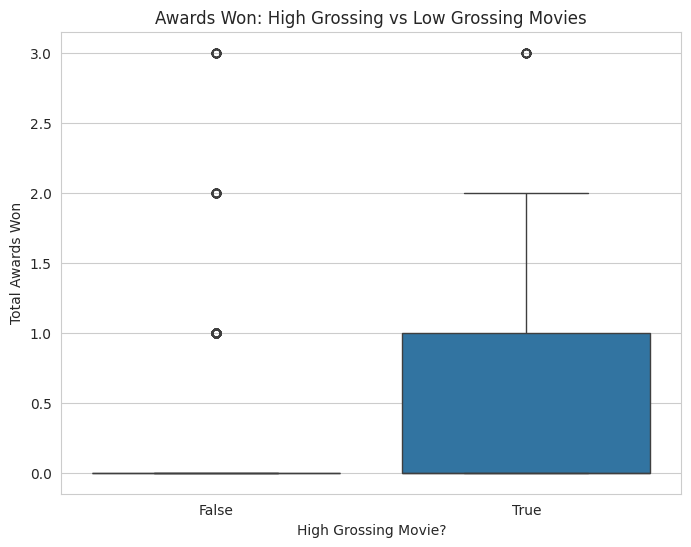

Is_High_Gross
False   0
True    1
Name: Total_Awards_Won, dtype: float64


In [58]:
#Do high-grossing movies have better chances of winning awards, regardless of release timing?

threshold = final_df['Worldwide Gross'].quantile(0.75)

final_df['Is_High_Gross'] = final_df['Worldwide Gross'] >= threshold

# Boxplot to compare
plt.figure(figsize=(8,6))
sns.boxplot(x='Is_High_Gross', y='Total_Awards_Won', data=final_df)
plt.title('Awards Won: High Grossing vs Low Grossing Movies')
plt.xlabel('High Grossing Movie?')
plt.ylabel('Total Awards Won')
plt.show()


mean_awards_gross = final_df.groupby('Is_High_Gross')['Total_Awards_Won'].mean()
print(mean_awards_gross)


#High box office success is correlated with winning more awards.
#High-grossing movies tend to win more awards regardless of release season.


In [59]:
# Check basic statistics and how many movies won 0 awards
print(final_df['Total_Awards_Won'].describe())

zero_awards = (final_df['Total_Awards_Won'] == 0).sum()
print(f"Movies with 0 awards: {zero_awards} out of {len(final_df)}")


count   15996
mean        0
std         0
min         0
25%         0
50%         0
75%         0
max         3
Name: Total_Awards_Won, dtype: float64
Movies with 0 awards: 15756 out of 15996


In [60]:
from scipy.stats import ttest_ind

# Separate groups
high_gross_awards = final_df[final_df['Is_High_Gross'] == True]['Total_Awards_Won']
low_gross_awards = final_df[final_df['Is_High_Gross'] == False]['Total_Awards_Won']

# Perform t-test
t_stat, p_value = ttest_ind(high_gross_awards, low_gross_awards, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.5f}")


T-statistic: 8.073
P-value: 0.00000


Release Season
Holiday Season       1
Awards Season        0
Summer Blockbuster   0
Spring               0
Name: Total_Awards_Won, dtype: float64


<ipython-input-48-1dba417c3eb5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_awards.index, y=season_awards.values, palette="viridis")


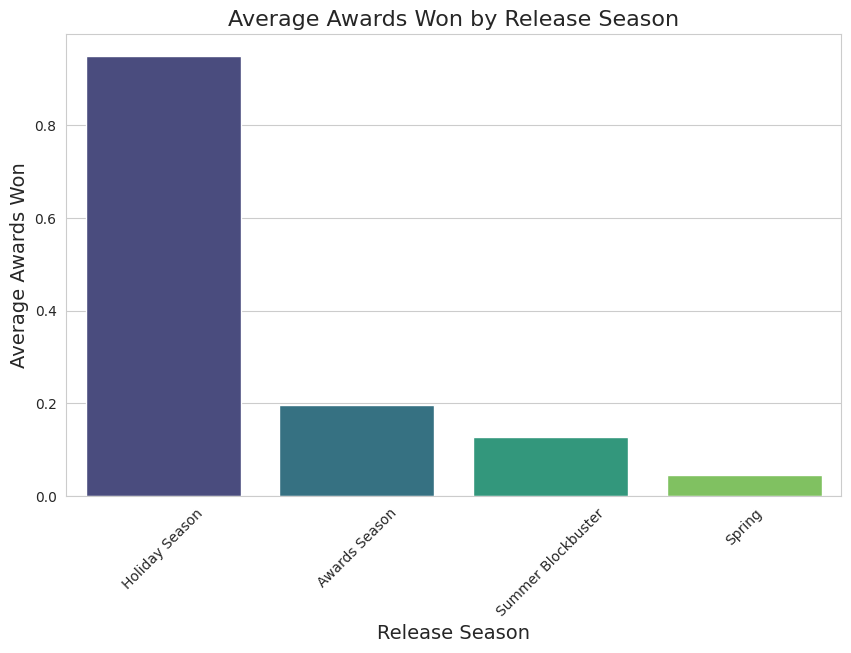

In [ ]:
# Group by season and calculate the mean number of awards
season_awards = final_df.groupby('Release Season')['Total_Awards_Won'].mean().sort_values(ascending=False)


print(season_awards)

#Plot for better visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x=season_awards.index, y=season_awards.values, palette="viridis")
plt.title('Average Awards Won by Release Season', fontsize=16)
plt.xlabel('Release Season', fontsize=14)
plt.ylabel('Average Awards Won', fontsize=14)
plt.xticks(rotation=45)
plt.show()


In [ ]:
from scipy.stats import f_oneway

# Separate the awards data by season
holiday_awards = final_df[final_df['Release Season'] == 'Holiday Season']['Total_Awards_Won']
awards_season_awards = final_df[final_df['Release Season'] == 'Awards Season']['Total_Awards_Won']
summer_awards = final_df[final_df['Release Season'] == 'Summer Blockbuster']['Total_Awards_Won']
spring_awards = final_df[final_df['Release Season'] == 'Spring']['Total_Awards_Won']

#One-way ANOVA
f_stat, p_value = f_oneway(holiday_awards, awards_season_awards, summer_awards, spring_awards)

print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.5f}")


F-statistic: 131.126
P-value: 0.00000


In [ ]:
print(final_df.columns)


Index(['Title', 'Release Year', 'Release Month', 'Release Date',
       'Release Season', 'Worldwide Gross', 'Oscar_Win', 'GG_Win', 'BAFTA_Win',
       'Total_Awards_Won', 'Is_Awards_Season', 'Is_High_Gross'],
      dtype='object')


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_df = final_df[['Release Season', 'Is_High_Gross', 'Total_Awards_Won']].dropna().rename(columns={'Release Season': 'Release_Season'})


#Two-Way ANOVA


model = ols('Total_Awards_Won ~ C(Release_Season) + C(Is_High_Gross) + C(Release_Season):C(Is_High_Gross)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)



                                    sum_sq    df    F  PR(>F)
C(Release_Season)                     1340     3  131       0
C(Is_High_Gross)                     11191     1 3283       0
C(Release_Season):C(Is_High_Gross)    3025     3  296       0
Residual                             55508 16286  NaN     NaN
